In [1]:
# code for a UNet architecture for learning how to remove 
# the foreground from a 21ccm signal

from __future__ import absolute_import, division, print_function
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from tensorflow.python.client import device_lib
import pickle
from sklearn.externals.joblib import dump, load
import h5py
import healpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import multiprocessing
import json

import tensorflow_transform as tft

/mnt/home/tmakinen/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
/mnt/home/tmakinen/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib

In [2]:
# plot settings
import matplotlib

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

In [50]:
def preprocessing_fn(inputs, ncomp=3):
    
    #inputs = tf.Tensor(inputs)
    inshape = inputs.shape
    inputs = tf.reshape(inputs, (-1, inputs.shape[-1])) # flatten inputs
    print(inputs.shape)
    #X = tf.placeholder(tf.float32, shape=inshape)
    
    #X = X.reshape()
    #inputs = tf.unstack(inputs, axis=0) # defaults to axis 0, returns a list of tensors
    
    
    features = []
    #outputs = {}
    #for feature_tensor in inputs:
        # standard scaler pre-req for PCA
        #features.append(tft.scale_to_z_score(feature_tensor))
    feature_matrix = tft.scale_to_z_score(inputs)
        
    # concat to make feature matrix for PCA to run over
    #feature_matrix = tf.concat(features, axis=0)  
    print(feature_matrix.shape)
    
    # get orthonormal vector matrix
    orthonormal_vectors = tft.pca(feature_matrix, output_dim=inputs.shape[0], dtype=tf.float64)
    
    
    # multiply matrix by feature matrix to get projected transformation
    obs_pca = tf.linalg.matmul(feature_matrix, orthonormal_vectors)
    
    ind_arr = tf.reshape(tf.range(np.prod(inputs.shape)),inputs.shape)

    
    mask = tf.ones(inputs.shape, dtype=tf.float64)
    print(mask.shape)
    mask = tf.Variable(mask)#tf.unstack(mask, num=mask.shape[0], axis=0)
    
    for i in range(ncomp,obs_pca.shape[1]):
        mask = tf.where((ind_arr%obs_pca.shape[1]==i), tf.zeros_like(mask), mask)

    
    #for i in range(ncomp,obs_pca.shape[1]):
        #mask[ind_arr%obs_pca.shape[1]==i] = 0
    
    #print(mask.shape)
    
    #mask = tf.concat(mask, axis=0)
    #print(mask.shape)
    
    #obs_pca = tf.tensordot(obs_pca, mask, axes=0)
    obs_pca_red = obs_pca*mask #tf.tensordot((obs_pca), (inputs), axes=1) #pca.inverse_transform(obs_pca)
    
    #X_new = tf.tensordot((pca_examples), (inputs), axes=1)
    
    # now subtract out the biggest components
    outputs = tf.subtract(inputs,  obs_pca_red).reshape(inshape)
    
    
    # unstack and add to output dict
    #pca_examples = tf.unstack(pca_examples, axis=1)
    #outputs['Principal Component 1'] = pca_examples[0]
    #outputs['Principal Component 2'] = pca_examples[1]


    return outputs

In [ ]:
tf.compat.v1.disable_eager_execution()
pca3_test = preprocessing_fn(obs, 3).numpy()


In [3]:
# bring in data 
obs = np.load('/mnt/home/tmakinen/ceph/deep21_results/unpolarized/examples/obs-single.npy')
cosmo = np.load('/mnt/home/tmakinen/ceph/deep21_results/unpolarized/examples/cosmo-single.npy')
pca3_precomputed = np.load('/mnt/home/tmakinen/ceph/deep21_results/unpolarized/examples/pca3-single.npy')

In [27]:

# first some additional packages that we'll need
import healpy as hp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------------
def gen_rearr(nside):
    # recursive funtion for finding the right 
    # ordering for the nested pixels 
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

# ----------------------------------------------------------------------------

# for this demo, we'll pull in a pre-computed index to get our data
# from the shape (192, N_x, N_y, N_nu) to the HEALPix ring
# data format (192*64*64, 64)

def pca_subtraction(input_map, n_comp, index_array=None, n_nu=None, 
                    nu_arr=None, nu_start=0, n_nu_out=64, n_nu_avg=3):
  
    # "GLOBAL" parameters ----------------------------------------------------
    MAP_NSIDE = 256
    SIM_NSIDE = MAP_NSIDE
    WINDOW_NSIDE = 4
    NUM_SIMS = 1
    # resolution of the outgoing window
    NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
    # actual side length of window
    WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))
    # ------------------------------------------------------------------------

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))
  
    if nu_arr is not None:
        print('working in frequency range ', nu_arr[nu_start], '--', 
                                nu_arr[nu_start + (n_nu*n_nu_avg)-1], 
                ' MHz')
    # original tensor shape
    sample_shape = input_map.shape
    
    # initialize the PCA algorithm
    pca = PCA()
    # allocate the output array
    pca_reduced_out = np.zeros(input_map.shape)
    
    # flatten input map into full-sky maps stacked in frequency
    input_map = input_map.reshape((-1, 64))#[index_array]
  
    # do PCA removal of n_comp components
    pca.fit(input_map)
    obs_pca = pca.transform(input_map)
    ind_arr = np.reshape(np.arange(np.prod(obs_pca.shape)),obs_pca.shape)

  
    mask = np.ones(obs_pca.shape)
    for i in range(n_comp,obs_pca.shape[1]):
        mask[ind_arr%obs_pca.shape[1]==i] = 0
    obs_pca = obs_pca*mask
    obs_pca_red = pca.inverse_transform(obs_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    obs_pca_red = input_map - obs_pca_red

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation  
    inds_nest = hp.ring2nest(MAP_NSIDE,inds)

    pca_reduced_out = obs_pca_red.reshape(sample_shape)
    

#     for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
#         # get the indices of the pixels which actually are in the larger pixel
#         inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
#         to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
#         to_rearr = obs_pca_red[inds_in]
#         to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
#         to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
#         ind = (0)*nwinds + PIX_SELEC
#         pca_reduced_out[ind] = to_rearr
                  
    return pca_reduced_out

In [53]:
pca3_test = pca_subtraction(obs[:20], 6)

Now I'm doing the minimum subtraction...
...removing the first 6 principal components


In [4]:
## 3D UNet for 21cm Observation De-Noising
## by TLM
## Import the required Libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv3D, BatchNormalization, Conv3DTranspose, concatenate,\
                                    MaxPool3D, Activation, LeakyReLU, Dropout, Add
from tensorflow.keras.regularizers import l2

class Asinh(tf.keras.layers.Layer):
    def __init__(self):
        super(Asinh, self).__init__()
        print("hello, look at this cool layer")

    def build(self, input_shape):
        self.a = self.add_weight(name='a',
            shape=(),
            initializer=tf.keras.initializers.Constant(1.),
            trainable=True)
        self.b = self.add_weight(name='b',
            shape=(),
            initializer=tf.keras.initializers.Constant(1.),
            trainable=True)
        self.c = self.add_weight(name='c',
            shape=(),
            initializer=tf.keras.initializers.Constant(0.),
            trainable=True)
        self.d = self.add_weight(name='d',
            shape=(),
            initializer=tf.keras.initializers.Constant(0.),
            trainable=True)

        super(Asinh, self).build(input_shape)

    def call(self, inputs):
        return self.a * tf.math.asinh(self.b * inputs + self.c) + self.d



class unet3D():  
    """
    General class for building fully connected 3D convolutional UNet
        Parameters: `n_filters`: starting filter size
                    `conv_width`: how many convolutions to be performed in residual block
                    `network_depth`: how many layers deep your network goes 
                        (limit: growth_factor^network_depth =< x_dim)
                    `growth_factor`: 2 (how to divide feature size)
                    `n_cubes_in`: how many image cubes to put into 4D inputs
                    `n_cubes_out`: number of cubes you want out
                    `x_dim`: image input size (x_dim, x_dim, x_dim)
                    `batchnorm`: bool (usually True) to reduce internal covariance shift
                    `momentum`: batchnorm param, set to 0.1 for outputs, (default=0.9)
                    `epsilon`: batchnorm param (default = 1e-5) 
                    `activation`: activation function for outputs (default = 'relu')
                    `maxpool`: whether or not to use MaxPool feature to downsample (default = True)
    """

    def __init__(self, n_filters = 16, conv_width=1, 
                 network_depth = 4,
                 n_cubes_in=1, n_cubes_out=1,
                 x_dim=32, nu_dim=32, dropout = 0.0, 
                 growth_factor=2, batchnorm_in=True,
                 batchnorm_down=True, batchnorm_up=False,
                 batchnorm_out=False,
                 out_act = False, 
                 momentum=0.1, epsilon=1e-5,
                 activation='relu', maxpool=False,
                 weight_decay = 1e-7
                 ):
        
        self.n_filters = n_filters
        self.n_cubes_in = n_cubes_in
        self.n_cubes_out = n_cubes_out
        self.conv_width = conv_width
        self.network_depth = network_depth
        self.x_dim = x_dim
        self.nu_dim = nu_dim
        self.dropout = dropout
        self.growth_factor = growth_factor
        self.batchnorm_in = batchnorm_in
        self.batchnorm_down = batchnorm_down
        self.batchnorm_up = batchnorm_up
        self.batchnorm_out = batchnorm_out
        self.out_act = out_act,
        self.momentum = momentum
        self.epsilon = epsilon
        self.activation = activation
       # self.maxpool = maxpool        
        self.wd = weight_decay
        #self.initializer = tf.keras.initializers.he_normal(seed=12)
        # define all layers
        
    def conv_block(self, x, n_filters, n_layers=1, strides=1, kernel_size=3, \
                           momentum=0.9,  batchnorm=True, layer_num=None):
        """Function to add n_blocks convolutional layers with the parameters passed to it"""
        if layer_num is not None:
            if strides > 1:
                name = 'downsample_{}'.format(layer_num)
        else:
            name = None
        
        for l in range(n_layers):      

            x = Conv3D(filters = n_filters, kernel_size = (kernel_size, kernel_size, kernel_size),\
                      padding = 'same', strides=strides, name=name)(x)
            if batchnorm:
                x = BatchNormalization(momentum=momentum)(x)
            x = Activation(self.activation)(x)
                
        return x           
                     
    
    def build_model(self):
        network_depth = self.network_depth
        n_filters = self.n_filters
        growth_factor = self.growth_factor
        x_dim = self.x_dim
        nu_dim = self.nu_dim
        momentum = self.momentum

        # start with inputs
        inputs = keras.layers.Input(shape=(x_dim, x_dim, nu_dim, self.n_cubes_in),name="image_input")
        x = Asinh()(inputs)
        concat_down = []
        # downsample path
        for l in range(network_depth):
            x = self.conv_block(x, n_filters, n_layers=self.conv_width,strides=1, batchnorm=self.batchnorm_in, momentum=momentum) 
            concat_down.append(x)
            n_filters *= growth_factor
            x = self.conv_block(x, n_filters, n_layers=1, batchnorm=self.batchnorm_down, momentum=momentum,
                                strides=2, layer_num=l+1)
        
        # reverse order of down layers
        concat_down = concat_down[::-1]  
        # middle
        x = self.conv_block(x, n_filters, n_layers=self.conv_width, strides=1)
        
        # expansive path
        for l in range(network_depth):
            if l+1 == network_depth:
                batchnorm_out = False            # remove batchnormalization for last convolution block
                batchnorm_up = False
            else:
                batchnorm_out = self.batchnorm_out
                batchnorm_up = self.batchnorm_up
            
            n_filters //= growth_factor   
            x = Conv3DTranspose(n_filters, kernel_size=3, strides=2, padding='same')(x)
            if batchnorm_up:            
                x = BatchNormalization(momentum=momentum, epsilon=self.epsilon)(x)
            if self.out_act:
                x = Activation(self.activation)(x)
            x = concatenate([x, concat_down[l]])
            x = self.conv_block(x, n_filters, n_layers=self.conv_width, kernel_size=3, 
                                        strides=1, batchnorm=batchnorm_out, momentum=self.momentum)   
            
        output = Conv3DTranspose(self.n_cubes_out,1,padding="same",name="output")(x)

        # return model
        model = keras.models.Model(inputs=inputs,outputs=output)
        return model


In [5]:
# DEFINE UNET INPUT PARAMS
params = {
    'nu_dim'        : 64,
    'x_dim'         : 64,
    'n_filters'     : 32,
    'conv_width'    : 3,
    'network_depth' : 3,
    'batch_size'    : 16,
    'num_epochs'    : 50,
    'act'           : 'relu',
    'lr'            : 0.0002,
    'wd'            : 1e-5,
    'batchnorm_in'  : True,
    'batchnorm_out' : True,
    'batchnorm_up'  : True,
    'batchnorm_down': True,
    'momentum'      :  0.02,
    'model_num'     : 1,
    'load_model'    : False,
}

net = unet3D(n_filters=params['n_filters'],
                      conv_width=params['conv_width'],
                      nu_dim=params['nu_dim'],
                      x_dim=params['x_dim'],
                      network_depth=params['network_depth'],
                      batchnorm_down=params['batchnorm_down'],
                      batchnorm_in=params['batchnorm_in'],
                      batchnorm_out=params['batchnorm_out'],
                      batchnorm_up=params['batchnorm_up'],
                      momentum=params['momentum']
                      )
net = net.build_model()

net.compile(optimizer=tf.optimizers.Adam(learning_rate=params['lr'],
                                                 beta_1=0.9, beta_2=0.999, amsgrad=False),
                                                 loss="logcosh",metrics=["mse", "logcosh"])

hello, look at this cool layer
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
x = np.expand_dims(obs, axis=-1)
y = np.expand_dims(cosmo, axis=-1)

N_TRAIN = int(0.8*192)
N_VAL  = int(0.2*192)

x_train = x[:N_TRAIN]
x_val   = x[N_TRAIN:-N_VAL]
x_test  = x[-N_VAL:]

y_train = y[:N_TRAIN]
y_val   = y[N_TRAIN:-N_VAL]
y_test  = y[-N_VAL:]

In [9]:
history = net.fit(x_train, y_train, batch_size=4, epochs=10,
                  validation_data=(x_val, y_val))

Epoch 1/10
39/39 [==============================] - 17s 430ms/step - loss: 0.0245 - mse: 0.0514 - logcosh: 0.0245
Epoch 2/10
39/39 [==============================] - 16s 416ms/step - loss: 0.0244 - mse: 0.0511 - logcosh: 0.0244
Epoch 3/10
39/39 [==============================] - 16s 417ms/step - loss: 0.0244 - mse: 0.0511 - logcosh: 0.0244
Epoch 4/10
39/39 [==============================] - 16s 417ms/step - loss: 0.0243 - mse: 0.0510 - logcosh: 0.0243
Epoch 5/10
39/39 [==============================] - 17s 430ms/step - loss: 0.0243 - mse: 0.0509 - logcosh: 0.0243
Epoch 6/10
39/39 [==============================] - 16s 420ms/step - loss: 0.0243 - mse: 0.0509 - logcosh: 0.0243
Epoch 7/10
39/39 [==============================] - 16s 418ms/step - loss: 0.0243 - mse: 0.0509 - logcosh: 0.0243
Epoch 8/10
39/39 [==============================] - 16s 418ms/step - loss: 0.0243 - mse: 0.0509 - logcosh: 0.0243
Epoch 9/10
39/39 [==============================] - 16s 418ms/step - loss: 0.0243 - mse:

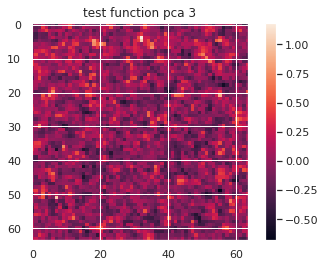

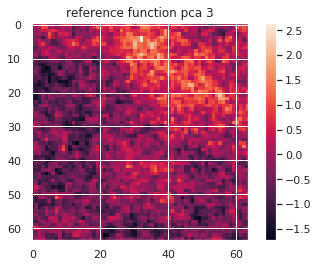

In [36]:
plt.title('test function pca 3')
plt.imshow(pca3_test[0].T[0])
plt.colorbar()
plt.show()

plt.title('reference function pca 3')
plt.imshow(pca3_precomputed[0].T[0])
plt.colorbar()
plt.show()